## **INTRODUCTION**

Dataset yang digunakan pada Notebook ini dapat dilihat pada [link](https://www.kaggle.com/trolukovich/food11-image-dataset).

Pada Notebook ini akan dilakukan Image Multi-Classification terhadap foto Makanan dengan jumlah kelas sebanyak 11, yaitu:
1. Bread
2. Dairy product
3. Dessert
4. Egg
5. Fried food
6. Meat
7. Noodles-Pasta
8. Rice
9. Seafood
10. Soup
11. Vegetable-Fruit

Proses pembuatan model pada Notebook ini akan menggunakan metode transfer learning dan fine tuning dari Model Inception V3.

## **IMPORT LIBRARIES**

In [1]:
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf

import random
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import time
from datetime import timedelta
import random

## **DATA LOADING**

In [2]:
train_dir = r'training/'
val_dir = r'validation/'
test_dir = r'testing/'

## **DATA EXPLORATION**

In [5]:
data_dir = pathlib.Path(train_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

9866


Terdapat 9866 foto pada data train.

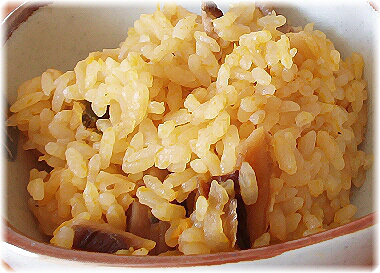

In [4]:
rice = list(data_dir.glob('Rice/*'))
PIL.Image.open(str(rice[0]))

## **DATA PREPROCESSING**

In [5]:
keras.backend.clear_session()
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [6]:
IMG_SIZE = (250,250)
BATCH_SIZE = 32

**Membuat dataset train, val, dan test**

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode='categorical')


Found 9866 files belonging to 11 classes.


In [8]:
val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode='categorical')

Found 3430 files belonging to 11 classes.


In [9]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=(IMG_SIZE),
                                                            label_mode='categorical')


Found 3347 files belonging to 11 classes.


**Membuat label klasifikasi**

In [10]:
class_names = train_dataset.class_names
print(class_names)

['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']


In [11]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 250, 250, 3)
(32, 11)


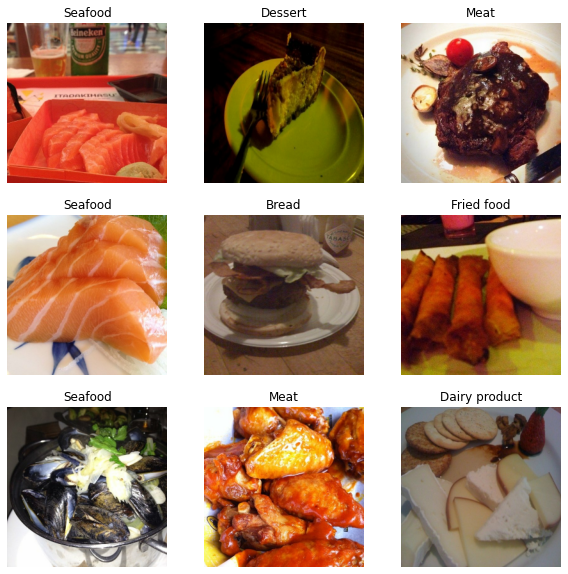

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[list(labels[i]).index(1)])
    plt.axis("off")

**Melihat jumlah batch pada train, val dan test**

In [13]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 309
Number of validation batches: 108
Number of test batches: 105


**Preprocess: Data Augmentation dan Model Input**

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal',seed=0),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.3,seed=0),
  tf.keras.layers.RandomZoom(height_factor=(-.5,.2), width_factor=(-.5,.2),
                            fill_mode='reflect', seed=0),
  tf.keras.layers.RandomCrop(200, 200, seed=0)
])

In [15]:
preprocess_layer = tf.keras.applications.inception_v3.preprocess_input

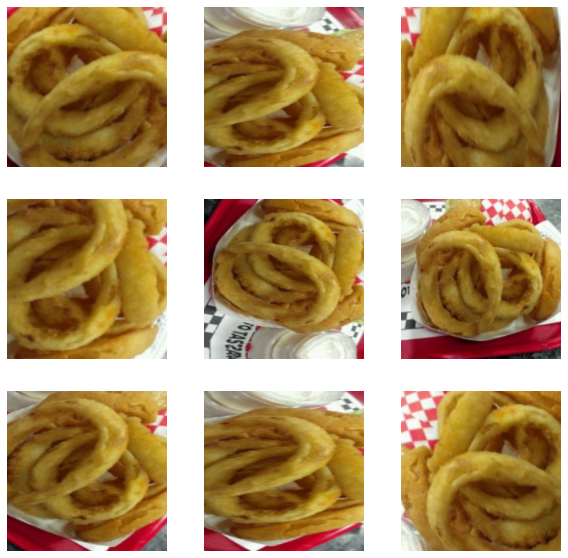

In [16]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(5000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## **MODEL BUILDING**

**Mendefinisikan Function**

In [18]:
def model_build(base_model):
    inputs = tf.keras.Input(shape=(250, 250, 3))

    x = data_augmentation(inputs)
    x = preprocess_layer(x)

    x = base_model(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(11, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [19]:
def model_train(model, epoch, optimizers, cb_patience):
    model.compile(optimizer=optimizers,
              loss="categorical_crossentropy",
              metrics=['accuracy'])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=cb_patience,
                                                    restore_best_weights=True)

    start_time = time.monotonic()

    history = model.fit(
        train_ds,
        epochs = epoch,
        validation_data=val_ds,
        callbacks=early_stopping)

    end_time = time.monotonic()
    print(timedelta(seconds=end_time - start_time))
    return history

**Inception_V3**

In [20]:
# base_model inception_v3
IMG_SIZE = (200,200)
IMG_SHAPE = IMG_SIZE + (3,)

inception_v3 = tf.keras.applications.inception_v3.InceptionV3(
                include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

In [21]:
inception_v3.trainable = True

In [22]:
## arsitektur algoritma inception_v3 (uncomment to see)
# keras.utils.plot_model(inception_v3)

In [23]:
# inisiasi pembuatan model
model_inception_v3 = model_build(base_model=inception_v3)

In [24]:
# meliihat arsitektur model
model_inception_v3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 200, 200, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 200, 200, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 200, 200, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0     

## **MODEL TRAINING**

In [25]:
history = model_train(model = model_inception_v3, epoch=25, optimizers=tf.keras.optimizers.Adamax(learning_rate=0.0001), cb_patience=3)

Epoch 1/25
309/309 [==============================] - 192s 478ms/step - loss: 2.6909 - accuracy: 0.2793 - val_loss: 1.3471 - val_accuracy: 0.5741
Epoch 2/25
309/309 [==============================] - 149s 484ms/step - loss: 1.7951 - accuracy: 0.4863 - val_loss: 1.1122 - val_accuracy: 0.6595
Epoch 3/25
309/309 [==============================] - 146s 472ms/step - loss: 1.4441 - accuracy: 0.5873 - val_loss: 0.9179 - val_accuracy: 0.7242
Epoch 4/25
309/309 [==============================] - 145s 468ms/step - loss: 1.2628 - accuracy: 0.6378 - val_loss: 0.8533 - val_accuracy: 0.7493
Epoch 5/25
309/309 [==============================] - 143s 462ms/step - loss: 1.0982 - accuracy: 0.6829 - val_loss: 0.7692 - val_accuracy: 0.7761
Epoch 6/25
309/309 [==============================] - 142s 459ms/step - loss: 0.9754 - accuracy: 0.7060 - val_loss: 0.7469 - val_accuracy: 0.7831
Epoch 7/25
309/309 [==============================] - 144s 465ms/step - loss: 0.9070 - accuracy: 0.7318 - val_loss: 0.6726 -

## **MODEL EVALUATION**

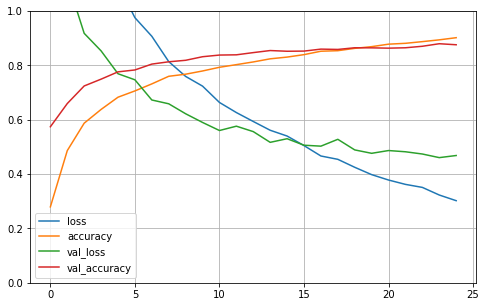

In [26]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

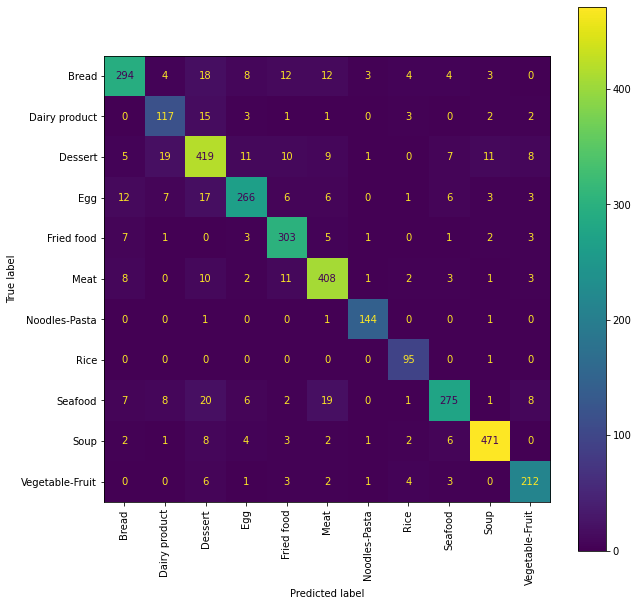

Classification Report
                 precision    recall  f1-score   support

          Bread       0.88      0.81      0.84       362
  Dairy product       0.75      0.81      0.78       144
        Dessert       0.82      0.84      0.83       500
            Egg       0.88      0.81      0.84       327
     Fried food       0.86      0.93      0.90       326
           Meat       0.88      0.91      0.89       449
  Noodles-Pasta       0.95      0.98      0.96       147
           Rice       0.85      0.99      0.91        96
        Seafood       0.90      0.79      0.84       347
           Soup       0.95      0.94      0.95       500
Vegetable-Fruit       0.89      0.91      0.90       232

       accuracy                           0.88      3430
      macro avg       0.87      0.88      0.88      3430
   weighted avg       0.88      0.88      0.88      3430



In [27]:
pred = model_inception_v3.predict(val_ds)
pred = np.argmax(pred, axis=1)
true = tf.concat([y for x, y in val_ds], axis = 0).numpy()
true = np.argmax(true,axis=1)
target_names = class_names

# confution Matrix
fig,ax = plt.subplots(figsize=[10,10])
ConfusionMatrixDisplay.from_predictions(true,pred, display_labels=class_names, xticks_rotation='vertical',ax=ax)
plt.show()
# classification report
print('Classification Report')
print(classification_report(true, pred, target_names=target_names))

Berdasarkan evaluasi dari pembuatan model yang telah dilakukan, didapatkan:
- Performa terhadap model dari 25 epoch terindikasi overfitting dengan val_loss 0.46 - train_loss 0.30
- Performa terhadap data pengklasifikasian pada validation set menghasilkan akurasi sebesar 0.88.
- Model cukup baik mengklasifikasikan Fried food, Noodles-Pasta, Rice, Soup, dan Vegetable-Fruit ditunjukkan dengan akurasi diatas sama dengan 0.9.
- Kelas target dengan akurasi dibawah 0.8 ialah Dairy product, yaitu 0.78. Hal ini diduga terjadi karena kemiripan beberapa bentuk dan beberapa warna dari kelas Dairy product terhadap Dessert.

In [ ]:
def label_viz(kelas):
    path = list(data_dir.glob('{}/*'.format(kelas)))
    
    i = 0
    list_kelas = []
    while i < 6:
        img = random.choice(path)
        list_kelas.append(img)
        i += 1

    list_im = list_kelas
    imgs    = [ PIL.Image.open(i) for i in list_im ]
    # pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
    min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
    imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )

    # save that beautiful picture
    imgs_comb = PIL.Image.fromarray( imgs_comb)
    #imgs_comb.save( 'combo.jpg' )    

    display(imgs_comb)

<ipython-input-12-253a21a980f6>:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )


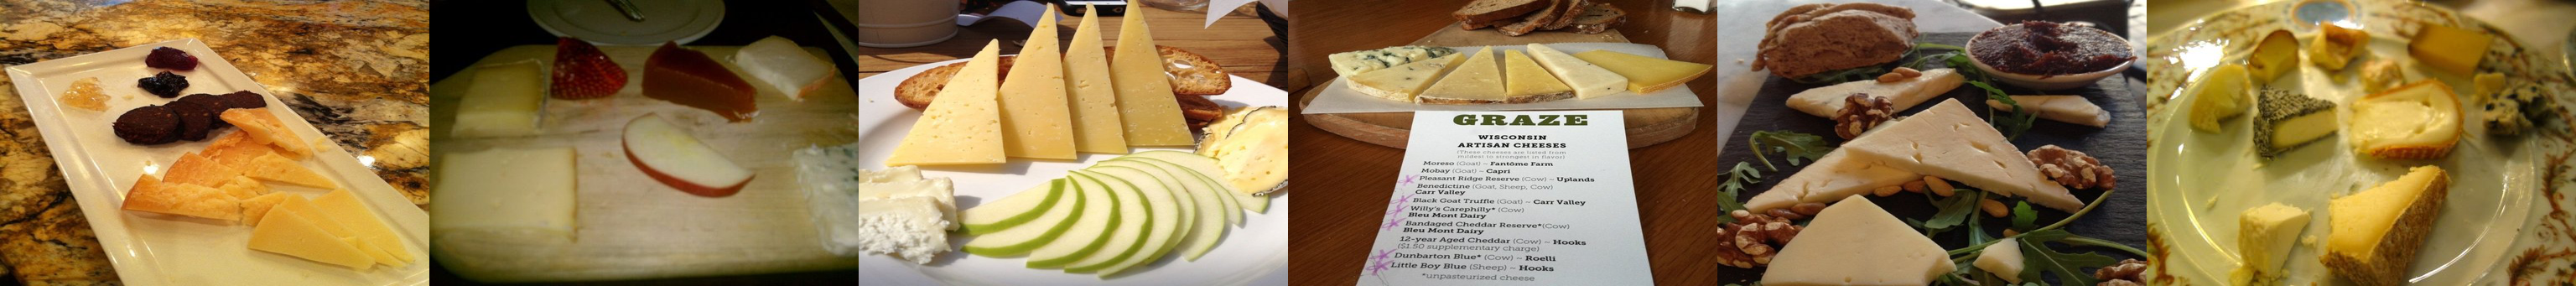

In [ ]:
label_viz('Dairy product')

<ipython-input-190-b2c87fb541f1>:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )


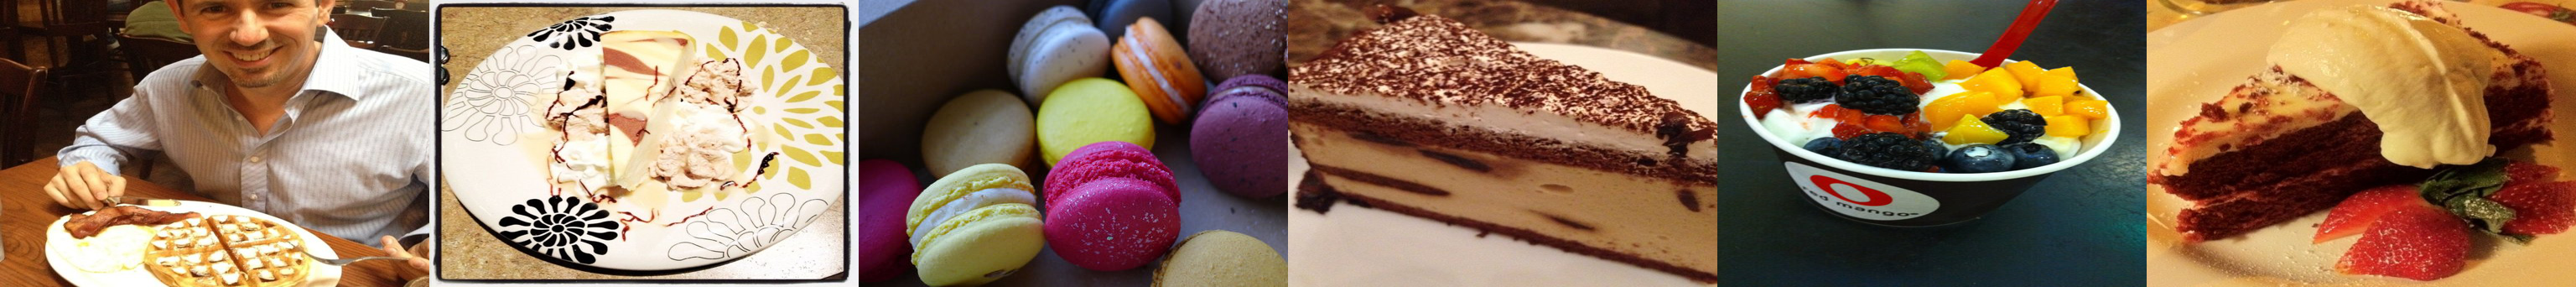

In [ ]:
label_viz('Dessert')

Dapat dilihat, beberapa jenis dessert dan dairy product memiliki kesamaan bentuk objek segitiga dengan warna yang saling mendekati. Hal ini diduga masih belum dapat dipelajari dengan baik oleh model.

## **MODEL SAVING**

In [31]:
model_inception_v3.save('inception_food_11.h5')

## **MODEL INFERENCE**

In [32]:
# load model
model = tf.keras.models.load_model('inception_food_11.h5')

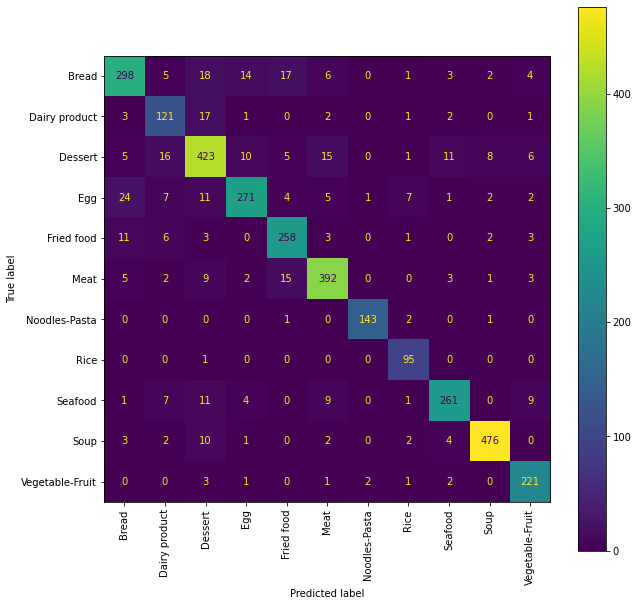

Classification Report
                 precision    recall  f1-score   support

          Bread       0.85      0.81      0.83       368
  Dairy product       0.73      0.82      0.77       148
        Dessert       0.84      0.85      0.84       500
            Egg       0.89      0.81      0.85       335
     Fried food       0.86      0.90      0.88       287
           Meat       0.90      0.91      0.90       432
  Noodles-Pasta       0.98      0.97      0.98       147
           Rice       0.85      0.99      0.91        96
        Seafood       0.91      0.86      0.88       303
           Soup       0.97      0.95      0.96       500
Vegetable-Fruit       0.89      0.96      0.92       231

       accuracy                           0.88      3347
      macro avg       0.88      0.89      0.88      3347
   weighted avg       0.89      0.88      0.88      3347



In [30]:
pred = model.predict(test_ds)
pred = np.argmax(pred, axis=1)
true = tf.concat([y for x, y in test_ds], axis = 0).numpy()
true = np.argmax(true,axis=1)

# confusion Matrix
fig,ax = plt.subplots(figsize=[10,10])
ConfusionMatrixDisplay.from_predictions(true,pred, display_labels=class_names, xticks_rotation='vertical',ax=ax)
plt.show()
# classification report
print('Classification Report')
print(classification_report(true, pred, target_names=class_names))

Hasil pengujian inference tidak jauh berbeda dengan hasil pengujian data validation set.

## **CONCLUSION**

Pada Notebook ini telah dilakukan pemodelan untuk mengklasifikasikan 11 kelas makanan berdasarkan foto.

Pada proses preprocessing terhadap data train dilakukan:
1. Random Flip secara Horizontal.
2. Random Rotation dengan rasio hingga 0.3.
3. Random Zoom dengan rasio antara Zoom in 0.5 hingga Zoom out 0.2.
4. Random Crop dengan perubahan Foto dari bentuk 250 x 250 menjadi 200 x 200.

Proses pembuatan model menggunakan metode Transfer Learning dengan algoritma Inception V3 dan Fine Tuning dengan melatih semua layer pada algoritma tersebut. Adapun total parameter yang dilatih sebanyak 24,134,315 parameter.

Hasil evaluasi dari pembuatan model didapatkan akurasi total sebesar 0.88.

Berdasarkan uji inferens terhadap data test, akurasi total yang didapatkan sebesar 0.88. Berdasarkan Classification report dan confussion matrix diketahui bahwa model masih memiliki kelemahan pada pengklasifikasian kelas Dairy Product. Hal ini diduga disebabkan karena beberapa objek pada Dairy Product memiliki kesamaan bentuk dan warna terhadap objek di label Dessert, sehingga model belum cukup mampu untuk membedakan dengan baik.

Evaluasi terhadap pengembangan lebih lanjut pada pemodelan di Notebook ini adalah dapat mencoba metode loss lainnya dalam pembuatan model agar performa dapat lebih baik.